## Importing

### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import re 
from sklearn import preprocessing
import numpy as np

### Import Data

In [68]:
url = 'https://raw.githubusercontent.com/sami12rom/Titanic/master/train.csv'
data = pd.read_csv(url)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Pre-processing

In [69]:
#Remove un-needed columns
data=data[data.columns.difference(['Name','Ticket'])]
data = data[['PassengerId','Survived','Age','Sex','Fare','Cabin','Embarked','Pclass','Parch','SibSp']]
										
#Replace null Ages with Median
data['Age'].fillna(data['Age'].median(), inplace=True)
data=data.dropna(subset=['Embarked'],axis=0)

#Combine Parents with Siblings to One Column
data['Family']=data['SibSp']+data['Parch']+1
data.drop(['SibSp','Parch'],axis=1,inplace=True)

#If he is Alone
data['Alone'] = [1 if x == 1 else 0 for x in data['Family']]

#Encode Sex
data['Sex'] = data['Sex'].replace(['male','female'],[1,0])

#Cabin Type One Hot Encode
t=data.Cabin.fillna('U')
data['Cabin']=t.str.slice(0,1)
data = pd.concat([data,pd.get_dummies(data['Cabin'],prefix='Cabin')],axis=1)
data = data.drop(['Cabin'],axis=1)

#Remove String from Tickets????
#data['Ticket_Numbers'] = data['Ticket'].str.replace('[^0-9]', '')
#data.loc[data['Ticket_Numbers']=='','Ticket_Numbers'] = 'NA'

#One Hot Encode the Pclass (Ticket Class)
data = pd.concat([data,pd.get_dummies(data['Pclass'],prefix='tktclass')],axis=1)
#data = data.drop(['Pclass'],axis=1)

#One Hot Encode the Embark Location
data['Embarked'] = data['Embarked'].replace(['S','C','Q'],['Southampton','Cherbourg','Queenstown'])
data=pd.concat([data,pd.get_dummies(data['Embarked'],prefix='Embark')],axis=1)
data.drop(['Embarked'],axis=1,inplace=True)

#Set PassengerId as Index
data=data.set_index('PassengerId')
data.head()

,Survived,Age,Sex,Fare,Pclass,Family,Alone,Cabin_A,Cabin_B,Cabin_C,...,Cabin_F,Cabin_G,Cabin_T,Cabin_U,tktclass_1,tktclass_2,tktclass_3,Embark_Cherbourg,Embark_Queenstown,Embark_Southampton
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,22.0,1,7.2500,3,2,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
2,1,38.0,0,71.2833,1,2,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
3,1,26.0,0,7.9250,3,1,1,0,0,0,...,0,0,0,1,0,0,1,0,0,1
4,1,35.0,0,53.1000,1,2,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
5,0,35.0,1,8.0500,3,1,1,0,0,0,...,0,0,0,1,0,0,1,0,0,1


<AxesSubplot:xlabel='Fare'>

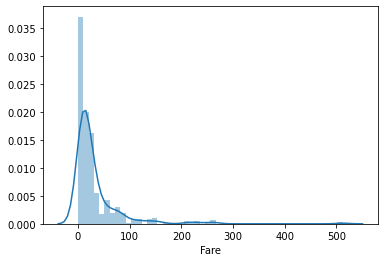

In [48]:
sns.distplot(data['Fare'])
#sns.distplot(data['Age'])

Text(0.5, 1.0, 'Correlations after one-hot encoding')

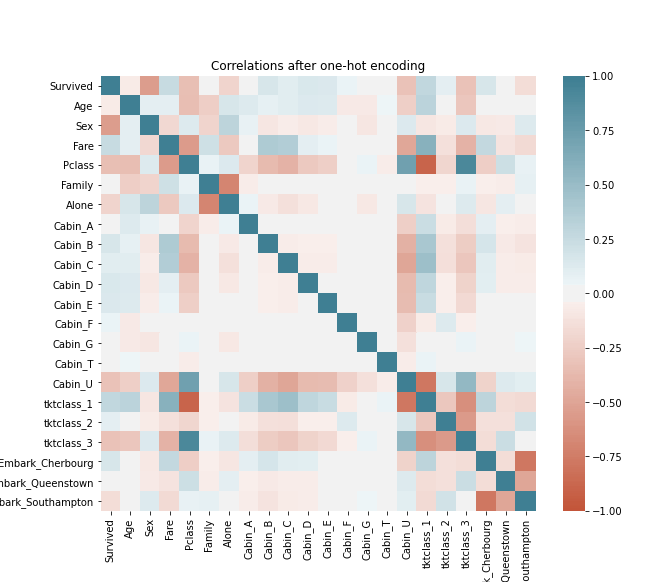

In [5]:
fig = plt.subplots(figsize=(10,8))
corr = data.corr()
ax = sns.heatmap(corr, vmin=-1, vmax=1,center=0, 
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)#, annot=True)
plt.title('Correlations after one-hot encoding')

## Feature Normalizing & Engineering

In [72]:
#Features = data.columns.difference(['Survived'])
#x = data[Features]
x = data.loc[:,data.columns != 'Cabin_T']
x = x.loc[:,x.columns != 'Survived']
y=data['Survived'].values
x

,Age,Sex,Fare,Pclass,Family,Alone,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_U,tktclass_1,tktclass_2,tktclass_3,Embark_Cherbourg,Embark_Queenstown,Embark_Southampton
PassengerId,,,,,,,,,,,,,,,,,,,,
1,22.0,1,7.2500,3,2,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
2,38.0,0,71.2833,1,2,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
3,26.0,0,7.9250,3,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1
4,35.0,0,53.1000,1,2,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
5,35.0,1,8.0500,3,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,27.0,1,13.0000,2,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1
888,19.0,0,30.0000,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1
889,28.0,0,23.4500,3,4,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1


In [73]:
x= preprocessing.StandardScaler().fit(x).transform(x)
x

array([[-0.56367407,  0.73534203, -0.50023975, ..., -0.48271079,
        -0.30794088,  0.61679395],
       [ 0.66921696, -1.35991138,  0.78894661, ...,  2.07163382,
        -0.30794088, -1.62128697],
       [-0.25545131, -1.35991138, -0.48664993, ..., -0.48271079,
        -0.30794088,  0.61679395],
       ...,
       [-0.10133993, -1.35991138, -0.17408416, ..., -0.48271079,
        -0.30794088,  0.61679395],
       [-0.25545131,  0.73534203, -0.0422126 , ...,  2.07163382,
        -0.30794088, -1.62128697],
       [ 0.20688282,  0.73534203, -0.49017322, ..., -0.48271079,
         3.24737656, -1.62128697]])

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [75]:
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=4, stratify=y)
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)

Train set: (711, 20) (711,)
Test set: (178, 20) (178,)


## Classification

#### Logistic Regression

In [76]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(x_train,y_train)
print(LR)
yhatlr = LR.predict(x_test)
print("Prediction: ",yhatlr[0:5])
print("Sample    : ",y_test [0:5])
print("Logistic Regression Train set Accuracy: ", metrics.accuracy_score(y_train, LR.predict(x_train)))
print("Logistic Regression Test set Accuracy: ", metrics.accuracy_score(y_test, yhatlr))

LogisticRegression(C=0.01, solver='liblinear')
Prediction:  [0 1 1 1 0]
Sample    :  [1 1 1 0 0]
Logistic Regression Train set Accuracy:  0.819971870604782
Logistic Regression Test set Accuracy:  0.7584269662921348


### Support Vector Machine

param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf'],}#'epsilon': [0.05, 0.1, 0.5, 1, 5, 10, 20]}
grid = GridSearchCV(svm.SVC(),param_grid,refit = True, verbose=0, n_jobs=-1)
grid_result = grid.fit(x_train, y_train)
best_params = grid_result.best_params_
best_params

yhatgsvc=grid.predict(x_test)
print("Prediction: ",yhatgsvc [0:5])
print("Sample    : ",y_test [0:5])
print("SVM Train set Accuracy: ", metrics.accuracy_score(y_train, grid.predict(x_train)))
print("SVM Test set Accuracy: ", metrics.accuracy_score(y_test, yhatgsvc)

In [77]:
clf = svm.SVC(kernel='rbf')
print(clf)
clf.fit(x_train, y_train)
yhatsvm = clf.predict(x_test)
print("Prediction: ",yhatsvm [0:5])
print("Sample    : ",y_test [0:5])
print("SVM Train set Accuracy: ", metrics.accuracy_score(y_train, clf.predict(x_train)))
print("SVM Test set Accuracy: ", metrics.accuracy_score(y_test, yhatsvm))

SVC()
Prediction:  [0 1 1 1 0]
Sample    :  [1 1 1 0 0]
SVM Train set Accuracy:  0.8481012658227848
SVM Test set Accuracy:  0.7584269662921348


### Decision Tree

In [78]:
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
print(drugTree)
drugTree.fit(x_train,y_train)
predTree = drugTree.predict(x_test)
print ("Prediction: ",predTree [0:5])
print("Sample    : ",y_test [0:5])
print("Decision Tree Train set Accuracy: ", metrics.accuracy_score(y_train, drugTree.predict(x_train)))
print("Decision Tree Test set Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTreeClassifier(criterion='entropy', max_depth=4)
Prediction:  [0 1 1 0 0]
Sample    :  [1 1 1 0 0]
Decision Tree Train set Accuracy:  0.8523206751054853
Decision Tree Test set Accuracy:  0.7808988764044944


### KNN Nearest Neighbour

The best accuracy was with 0.7415730337078652 with k= 5


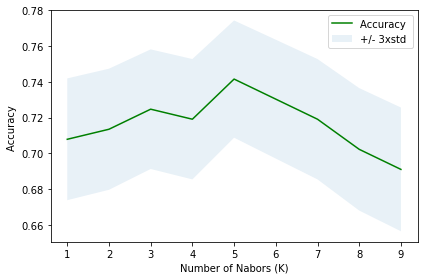

In [79]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(x_train,y_train)
    yhatknn=neigh.predict(x_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhatknn)

    
    std_acc[n-1]=np.std(yhatknn==y_test)/np.sqrt(yhatknn.shape[0])
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [80]:
k=5
nn = KNeighborsClassifier(n_neighbors = k).fit(x_train,y_train)
print(nn)

yhatknn = nn.predict(x_test)
print("Prediction: ",yhatknn[0:5])
print("Sample    : ",y_test [0:5])
print("Train set Accuracy: ", metrics.accuracy_score(y_train, nn.predict(x_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhatknn))

KNeighborsClassifier()
Prediction:  [0 0 1 0 0]
Sample    :  [1 1 1 0 0]
Train set Accuracy:  0.8509142053445851
Test set Accuracy:  0.7415730337078652


### Random Forest

In [81]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 100, random_state = 0, criterion='entropy')
# Train the model on training data
rf.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=0)

In [82]:
# Use the forest's predict method on the test data
yhatrf = rf.predict(x_test)
print("Prediction: ",yhatrf[0:5])
print("Sample    : ",y_test [0:5])
print("Train set Accuracy: ", metrics.accuracy_score(y_train, rf.predict(x_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhatrf))

Prediction:  [1 1 1 0 0]
Sample    :  [1 1 1 0 0]
Train set Accuracy:  0.9845288326300985
Test set Accuracy:  0.7865168539325843


### XGBoost Model

In [83]:
from xgboost import XGBClassifier

In [84]:
xgbc=XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=5, random_state=0)
xgbc.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [85]:
yhatxgb=xgbc.predict(x_test)
print("Prediction: ",yhatxgb[0:5])
print("Sample    : ",y_test [0:5])
print("Train set Accuracy: ", metrics.accuracy_score(y_train, xgbc.predict(x_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhatxgb))

Prediction:  [0 1 1 0 0]
Sample    :  [1 1 1 0 0]
Train set Accuracy:  0.9338959212376934
Test set Accuracy:  0.7808988764044944


## Apply Model on Unseen Dataset

In [86]:
url = 'https://raw.githubusercontent.com/sami12rom/Titanic/master/test.csv'
data = pd.read_csv(url)
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [87]:
#Set PassengerId as Index
data=data.set_index('PassengerId')
data.head()

#Remove un-needed columns
data=data[data.columns.difference(['Name','Ticket'])]
data = data[['Age','Sex','Fare','Cabin','Embarked','Pclass','Parch','SibSp']]
										
#Replace null Ages with Median
data['Age'].fillna(data['Age'].median(), inplace=True)
data=data.dropna(subset=['Embarked'],axis=0)

#Combine Parents with Siblings to One Column
data['Family']=data['SibSp']+data['Parch']+1
data.drop(['SibSp','Parch'],axis=1,inplace=True)

#If he is Alone
data['Alone'] = [1 if x == 1 else 0 for x in data['Family']]

#Encode Sex
data['Sex'] = data['Sex'].replace(['male','female'],[1,0])

#Cabin Type One Hot Encode
t=data.Cabin.fillna('U')
data['Cabin']=t.str.slice(0,1)
data = pd.concat([data,pd.get_dummies(data['Cabin'],prefix='Cabin')],axis=1)
data = data.drop(['Cabin'],axis=1)

#Remove String from Tickets????
#data['Ticket_Numbers'] = data['Ticket'].str.replace('[^0-9]', '')
#data.loc[data['Ticket_Numbers']=='','Ticket_Numbers'] = 'NA'

#One Hot Encode the Pclass (Ticket Class)
data = pd.concat([data,pd.get_dummies(data['Pclass'],prefix='tktclass')],axis=1)
#data = data.drop(['Pclass'],axis=1)

#One Hot Encode the Embark Location
data['Embarked'] = data['Embarked'].replace(['S','C','Q'],['Southampton','Cherbourg','Queenstown'])
data=pd.concat([data,pd.get_dummies(data['Embarked'],prefix='Embark')],axis=1)
data.drop(['Embarked'],axis=1,inplace=True)


In [88]:
data

,Age,Sex,Fare,Pclass,Family,Alone,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_U,tktclass_1,tktclass_2,tktclass_3,Embark_Cherbourg,Embark_Queenstown,Embark_Southampton
PassengerId,,,,,,,,,,,,,,,,,,,,
892,34.5,1,7.8292,3,1,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0
893,47.0,0,7.0000,3,2,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
894,62.0,1,9.6875,2,1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0
895,27.0,1,8.6625,3,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1
896,22.0,0,12.2875,3,3,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,27.0,1,8.0500,3,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1
1306,39.0,0,108.9000,1,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0
1307,38.5,1,7.2500,3,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1


In [89]:
Features = data.columns
x = data[Features]
x= preprocessing.StandardScaler().fit(x).transform(x)
x

array([[ 0.38623105,  0.75592895, -0.49781052, ..., -0.56814154,
         2.84375747, -1.35067551],
       [ 1.37137004, -1.32287566, -0.51265996, ..., -0.56814154,
        -0.35164743,  0.74037028],
       [ 2.55353683,  0.75592895, -0.46453181, ..., -0.56814154,
         2.84375747, -1.35067551],
       ...,
       [ 0.70147553,  0.75592895, -0.50818292, ..., -0.56814154,
        -0.35164743,  0.74037028],
       [-0.20485235,  0.75592895, -0.4938564 , ..., -0.56814154,
        -0.35164743,  0.74037028],
       [-0.20485235,  0.75592895, -0.23762123, ...,  1.76012477,
        -0.35164743, -1.35067551]])

In [90]:
yhatxgb=xgbc.predict(x)

In [128]:
result = pd.DataFrame(columns=['PassengerId','Survived'])
result['PassengerId'] = data.index.astype('str')
result['Survived'] = yhatxgb.astype('str')

In [129]:
result.to_csv('result.csv', index=False)